In [26]:
import torch
import torch.utils.data
from IPython import display
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import torch.nn.functional as F

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [27]:
# process anormaly data
data_train.drop(data_train[(data_train['OverallQual']<5) & (data_train['SalePrice']>200000)].index,inplace=True)
data_train.drop(data_train[(data_train['GrLivArea']>4000) & (data_train['SalePrice']<200000)].index,inplace=True)
data_train.drop(data_train[(data_train['YearBuilt']<1900) & (data_train['SalePrice']>400000)].index,inplace=True)
data_train.drop(data_train[(data_train['TotalBsmtSF']>6000) & (data_train['SalePrice']<200000)].index,inplace=True)
data_train.reset_index(drop=True, inplace=True)

In [28]:
# combine train and test data
all_data = pd.concat((data_train.iloc[:, 1:-1], data_test.iloc[:, 1:]))
print(all_data.shape)

(2915, 79)


In [29]:
# delete propeties with too much loss data and properties with less correlation to sale price
all_data = all_data.drop(["MiscFeature", "PoolQC", "Alley", "Fence","GarageFinish", "KitchenAbvGr", "MSSubClass", "LowQualFinSF", "MiscVal", "BsmtHalfBath", "BsmtFinSF2", "MoSold", "PoolArea"], axis=1)
print(all_data.shape)

(2915, 66)


In [30]:
# add loss data
# for GarageYrBlt, add 1980
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(1980)

In [31]:
# for numerial properties, add 0 (except for GarageYrBlt)
# for object properties, add NA
for col in all_data.columns:
    if all_data[col].isnull().sum() > 0:
        if all_data[col].dtypes == 'object':
            all_data[col] = all_data[col].fillna('NA')
        else:
            all_data[col] = all_data[col].fillna(0)

In [32]:
# feature enginering
# add new features
all_data['TotalArea'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] + all_data['GrLivArea'] +all_data['GarageArea']
all_data['Bathrooms'] = all_data['FullBath'] + all_data['HalfBath']*0.5 
all_data['Year average']= (all_data['YearRemodAdd']+all_data['YearBuilt'])/2

# space in house
all_data['HasWoodDeck'] = (all_data['WoodDeckSF'] == 0) * 1
all_data['HasOpenPorch'] = (all_data['OpenPorchSF'] == 0) * 1
all_data['HasEnclosedPorch'] = (all_data['EnclosedPorch'] == 0) * 1
all_data['Has3SsnPorch'] = (all_data['3SsnPorch'] == 0) * 1
all_data['HasScreenPorch'] = (all_data['ScreenPorch'] == 0) * 1

# year since remodel
all_data['YearsSinceRemodel'] = all_data['YrSold'] - all_data['YearRemodAdd']
# overall quality
all_data['Total_Home_Quality'] = all_data['OverallQual'] + all_data['OverallCond']

In [33]:
# normalization for numerial properties
numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index
all_data[numeric_features] = all_data[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [34]:
# convert non-numeric properties
all_data = pd.get_dummies(all_data)

In [35]:
all_data.shape

(2915, 291)

In [36]:
all_data.to_csv("all_data_dl.csv", index = False)

In [37]:
# to tensor
n_train = data_train.shape[0]
train_features = torch.tensor(all_data[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_data[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(data_train.SalePrice.values,dtype=torch.float).view(-1, 1)

In [38]:
print(train_features.shape)
print(test_features.shape)

torch.Size([1456, 291])
torch.Size([1459, 291])


In [39]:
# define model with one layer
class Linear(nn.Module):
    def __init__(self, feature_num):
        super(Linear, self).__init__()
        self.fc = nn.Linear(feature_num, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

In [40]:
# define model with two layers
class Linear2(nn.Module):
    def __init__(self, feature_num):
        super(Linear2, self).__init__()
        self.fc1 = nn.Linear(feature_num, 256)
        # self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x =  F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [41]:
# define model with three layers
class Linear3(nn.Module):
    def __init__(self, feature_num):
        super(Linear3, self).__init__()
        self.fc1 = nn.Linear(feature_num, 256)
        # self.bn1 = nn.BatchNorm1d(128)
        #self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(256, 128)
        #self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x =  F.relu(self.fc1(x))
        #x = self.dropout1(x)
        x =  F.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [42]:
def get_net(feature_num):
    net = Linear2(feature_num)
    return net
    
loss_func = nn.MSELoss()

In [43]:
# log mean square error loss
def log_rmse(net, features, labels):
    with torch.no_grad():
        # Set the value less than 1 to 1, to make the value more stable for log
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss_func(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

In [44]:
# train model
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    
    train_ls, test_ls = [], []

    dataset = torch.utils.data.TensorDataset(train_features, train_labels)

    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle = True)

    optimizer = torch.optim.Adam(params=net.parameters(), lr = learning_rate, weight_decay=weight_decay)
    net = net.float()

    for epoch in range(num_epochs):
        net.train()
        
        for data in train_iter:
            X, y = data     
            
            optimizer.zero_grad()
            
            loss = loss_func(net(X.float()), y.float())
            
            loss.backward()
            
            optimizer.step()
            
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [45]:
# loss figure
def use_svg_display():
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, 
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

In [46]:
# k-cross validation 
# returns train and validation data for i-fold cross-validation
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim = 0)
            y_train = torch.cat((y_train, y_part), dim = 0)
    return X_train, y_train, X_valid, y_valid

In [47]:
# train k times and return rmse of train and validation
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        semilogy(range(1, num_epochs + 1), train_ls,'epochs', 'rmse',range(1, num_epochs + 1), valid_ls,['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

In [90]:
# set hyperparameters
k, num_epochs, lr, weight_decay, batch_size = 5, 200, 0.04, 0.0001, 32

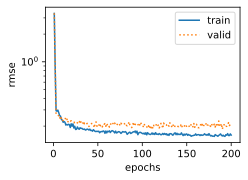

fold 0, train rmse 0.159608, valid rmse 0.203637


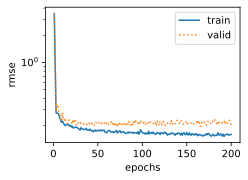

fold 1, train rmse 0.159081, valid rmse 0.202910


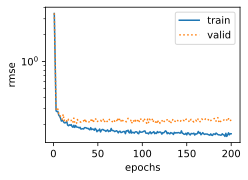

fold 2, train rmse 0.157055, valid rmse 0.210264


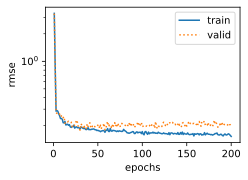

fold 3, train rmse 0.151128, valid rmse 0.197779


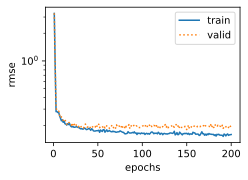

fold 4, train rmse 0.158681, valid rmse 0.196464
5-fold validation: avg train rmse 0.157111, avg valid rmse 0.202211


In [91]:
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' %(k, train_l, valid_l))

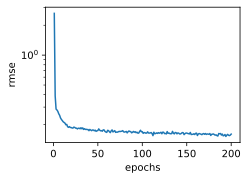

train rmse 0.160523
test rmse 0.066872


In [92]:
# prediction
def train_and_pred(train_features, test_features, train_labels, data_test, num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse')
    print('train rmse %f'%train_ls[-1])
    
    net.eval()
    
    preds = net(test_features).detach().numpy()
    data_test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    
    data_sample = pd.read_csv('submission_best.csv')
    labels = torch.tensor(data_sample.SalePrice.values,dtype=torch.float).view(-1, 1)
    
    clipped_preds = torch.max(net(test_features), torch.tensor(1.0))
    rmse = torch.sqrt(2 * loss_func(clipped_preds.log(), labels.log()).mean())
    print('test rmse %f'%rmse)
    
    
    submission = pd.concat([data_test['Id'], data_test['SalePrice']], axis=1)
    submission.to_csv("submission_dl.csv", index=False)

train_and_pred(train_features, test_features, train_labels, data_test, num_epochs, lr, weight_decay, batch_size)